# Walmart recruiting store sales forecasting

Data Description
You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

<h2> Reading Data</h2>

In [2]:
features  = pd.read_csv('features.csv')
#sample_sub  = pd.read_csv('sampleSubmission.csv')
stores=     pd.read_csv('stores.csv')
train=      pd.read_csv('train.csv')
test=       pd.read_csv('test.csv')
print("FEATURE.CSV")
print(features.columns)
#print("sample_submission.csv")
#print(sample_sub.columns)
print("stores.csv")
print(stores.columns)
print("train.csv")
print(train.columns)
print("test.csv")
print(test.columns)

FEATURE.CSV
Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')
stores.csv
Index(['Store', 'Type', 'Size'], dtype='object')
train.csv
Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')
test.csv
Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object')


In [3]:
dataset = pd.read_csv("train.csv", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
features = pd.read_csv("features.csv",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("stores.csv", names=['Store','Type','Size'],sep=',', header=0)
dataset = dataset.merge(stores, how='left').merge(features, how='left')

# dataset["nextWeekHoliday"] = dataset["isHoliday"].shift(-1).fillna(False)
# dataset["next2WeekHoliday"] = dataset["isHoliday"].shift(-2).fillna(False)
dataset

Store  Dept        Date  weeklySales  isHoliday Type    Size  \
0           1     1  2010-02-05     24924.50      False    A  151315   
1           1     1  2010-02-12     46039.49       True    A  151315   
2           1     1  2010-02-19     41595.55      False    A  151315   
3           1     1  2010-02-26     19403.54      False    A  151315   
4           1     1  2010-03-05     21827.90      False    A  151315   
5           1     1  2010-03-12     21043.39      False    A  151315   
6           1     1  2010-03-19     22136.64      False    A  151315   
7           1     1  2010-03-26     26229.21      False    A  151315   
8           1     1  2010-04-02     57258.43      False    A  151315   
9           1     1  2010-04-09     42960.91      False    A  151315   
10          1     1  2010-04-16     17596.96      False    A  151315   
11          1     1  2010-04-23     16145.35      False    A  151315   
12          1     1  2010-04-30     16555.11      False    A  151315   
13          1     1  2010-05-07     17413.94      False    A  151315   
14          1     1  2010-05-14     18926.74      False    A  151315   
15          1     1  2010-05-21     14773.04      False    A  151315   
16          1     1  2010-05-28     15580.43      False    A  151315   
17          1     1  2010-06-04     17558.09      False    A  151315   
18          1     1  2010-06-11     16637.62      False    A  151315   
19          1     1  2010-06-18     16216.27      False    A  151315   
20          1     1  2010-06-25     16328.72      False    A  151315   
21          1     1  2010-07-02     16333.14      False    A  151315   
22          1     1  2010-07-09     17688.76      False    A  151315   
23          1     1  2010-07-16     17150.84      False    A  151315   
24          1     1  2010-07-23     15360.45      False    A  151315   
25          1     1  2010-07-30     15381.82      False    A  151315   
26          1     1  2010-08-06     17508.41      False    A  151315   
27          1     1  2010-08-13     15536.40      False    A  151315   
28          1     1  2010-08-20     15740.13      False    A  151315   
29          1     1  2010-08-27     15793.87      False    A  151315   
...       ...   ...         ...          ...        ...  ...     ...   
421540     45    98  2012-04-06       778.70      False    B  118221   
421541     45    98  2012-04-13       559.14      False    B  118221   
421542     45    98  2012-04-20       605.80      False    B  118221   
421543     45    98  2012-04-27       619.41      False    B  118221   
421544     45    98  2012-05-04       694.25      False    B  118221   
421545     45    98  2012-05-11       893.60      False    B  118221   
421546     45    98  2012-05-18       745.44      False    B  118221   
421547     45    98  2012-05-25       795.94      False    B  118221   
421548     45    98  2012-06-01       874.64      False    B  118221   
421549     45    98  2012-06-08       713.50      False    B  118221   
421550     45    98  2012-06-15       856.35      False    B  118221   
421551     45    98  2012-06-22       622.62      False    B  118221   
421552     45    98  2012-06-29       690.52      False    B  118221   
421553     45    98  2012-07-06       659.65      False    B  118221   
421554     45    98  2012-07-13       695.21      False    B  118221   
421555     45    98  2012-07-20       845.30      False    B  118221   
421556     45    98  2012-07-27       657.63      False    B  118221   
421557     45    98  2012-08-03       516.46      False    B  118221   
421558     45    98  2012-08-10       727.49      False    B  118221   
421559     45    98  2012-08-17       500.16      False    B  118221   
421560     45    98  2012-08-24       415.40      False    B  118221   
421561     45    98  2012-08-31       346.04      False    B  118221   
421562     45    98  2012-09-07       352.44       True    B  118221   
421563     45    98  2012-09-14       605.96    

# Perspective of analysis

Sales can be reponsive to time factor and space factor

Store's sales records are the aggregation of each department

Date variable can be split into y/m/w/d variables

Day variable can provide much information on sales

Outside data such as national holiday of US will be combined to add information


# EDA

In [4]:
print(features.head(10))
print(features.shape)

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   
5      1  2010-03-12        57.79       2.667        NaN        NaN   
6      1  2010-03-19        54.58       2.720        NaN        NaN   
7      1  2010-03-26        51.45       2.732        NaN        NaN   
8      1  2010-04-02        62.27       2.719        NaN        NaN   
9      1  2010-04-09        65.86       2.770        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  
0        NaN        NaN        NaN  211.096358         8.106  
1        NaN        NaN        NaN  211.242170         8.106  
2        NaN        NaN      

In [5]:
print(stores.head(10))
print(stores.shape)

   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875
5      6    A  202505
6      7    B   70713
7      8    A  155078
8      9    B  125833
9     10    B  126512
(45, 3)


In [6]:
print(train.head(10))
print(train.shape)

   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
5      1     1  2010-03-12      21043.39      False
6      1     1  2010-03-19      22136.64      False
7      1     1  2010-03-26      26229.21      False
8      1     1  2010-04-02      57258.43      False
9      1     1  2010-04-09      42960.91      False
(421570, 5)


In [7]:
print(test.head(10))
print(test.shape)

   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False
5      1     1  2012-12-07      False
6      1     1  2012-12-14      False
7      1     1  2012-12-21      False
8      1     1  2012-12-28       True
9      1     1  2013-01-04      False
(115064, 4)


In [8]:
print("the unique value of store is", stores['Store'].unique())
print("the unique value of Type is", stores['Type'].unique())

the unique value of store is [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
the unique value of Type is ['A' 'B' 'C']


In [9]:
grouped=stores.groupby('Type')
print(grouped.describe()['Size'].round(2))

      count       mean       std      min        25%       50%       75%  \
Type                                                                       
A      22.0  177247.73  49392.62  39690.0  155840.75  202406.0  203819.0   
B      17.0  101190.71  32371.14  34875.0   93188.00  114533.0  123737.0   
C       6.0   40541.67   1304.15  39690.0   39745.00   39910.0   40774.0   

           max  
Type            
A     219622.0  
B     140167.0  
C      42988.0  


# Let's make a pie chart to show the ratio of A, B, and C types of total 45 Walmart stores.


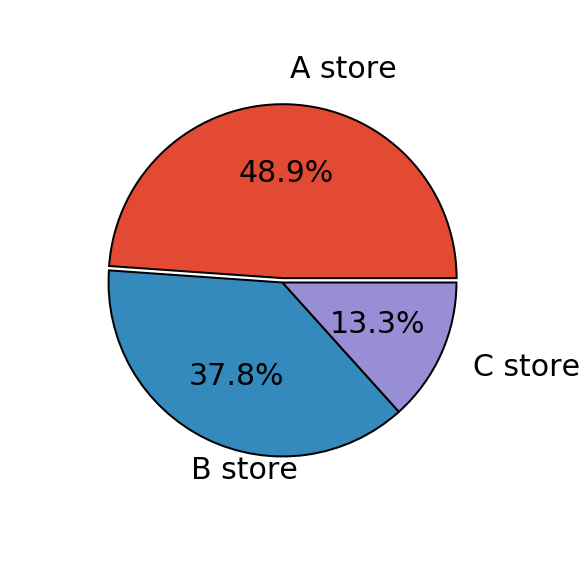

In [10]:
plt.style.use('ggplot')
labels=['A store','B store','C store']
sizes=grouped.describe()['Size'].round(1)
sizes=[(22/(17+6+22))*100,(17/(17+6+22))*100,(6/(17+6+22))*100] # convert to the proportion


fig, axes = plt.subplots(1,1, figsize=(10,10))

wprops={'edgecolor':'black',
      'linewidth':2}

tprops = {'fontsize':30}


axes.pie(sizes,
        labels=labels,
        explode=(0.02,0,0),
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.2,
        wedgeprops=wprops,
        textprops=tprops,
        radius=0.8,
        center=(0.5,0.5))
plt.show()


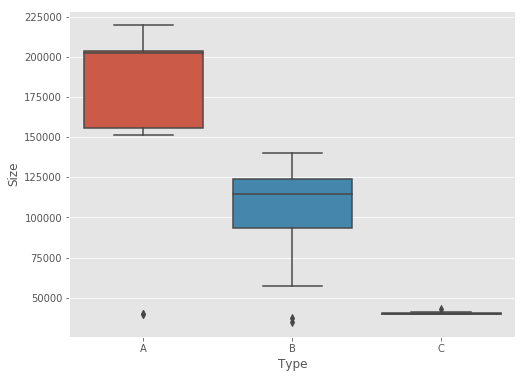

In [11]:
data = pd.concat([stores['Type'], stores['Size']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Size', data=data)

1. type A store is the largest store and C is the smallest
2. Even more, there is no overlapped area in size among A, B, and C. Type is the best predictor for Size


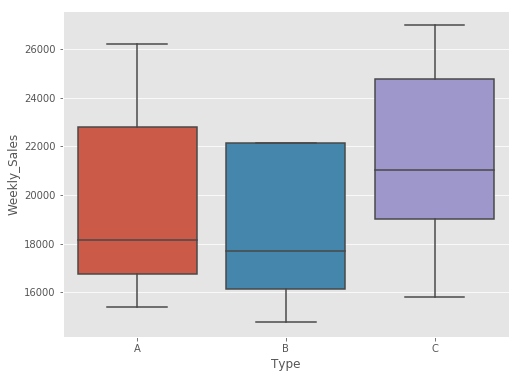

In [12]:
data = pd.concat([stores['Type'], train['Weekly_Sales']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Weekly_Sales', data=data, showfliers=False)


1. The median of A is the highest and C is the lowest
2. That means stores with more sizes have higher sales record (The order of median of size and median of sales is the same)

In [13]:
train=train.merge(stores, on='Store', how='left')
train.head()

Store  Dept        Date  Weekly_Sales  IsHoliday Type    Size
0      1     1  2010-02-05      24924.50      False    A  151315
1      1     1  2010-02-12      46039.49       True    A  151315
2      1     1  2010-02-19      41595.55      False    A  151315
3      1     1  2010-02-26      19403.54      False    A  151315
4      1     1  2010-03-05      21827.90      False    A  151315

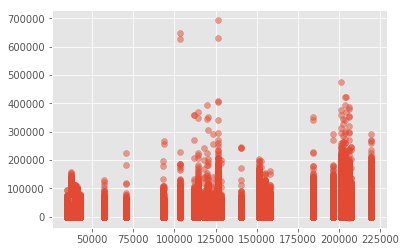

In [14]:
plt.style.use('ggplot')

fig=plt.figure()
ax=fig.add_subplot(111)

ax.scatter(train['Size'],train['Weekly_Sales'], alpha=0.5)

plt.show()

The result is not so good. There can be no distinct relation between size and sales.

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\legend.py:497: UserWarning:

Unrecognized location "higher right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center




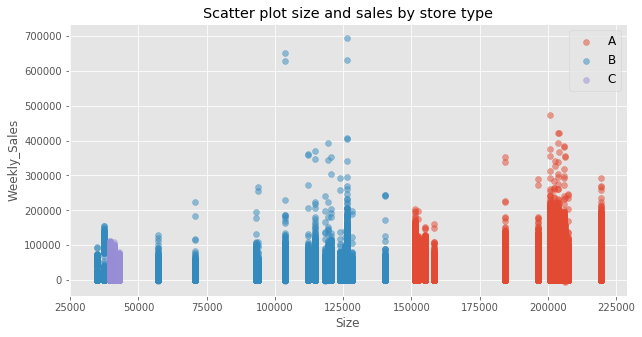

In [15]:
types=stores['Type'].unique()

plt.style.use('ggplot')

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)

for t in types:
    x=train.loc[train['Type']==t, 'Size']
    y=train.loc[train['Type']==t, 'Weekly_Sales']
    
    ax.scatter(x,y,alpha=0.5, label=t)

ax.set_title('Scatter plot size and sales by store type')
ax.set_xlabel('Size')
ax.set_ylabel('Weekly_Sales')

ax.legend(loc='higher right',fontsize=12)

plt.show()


Gives no additional information

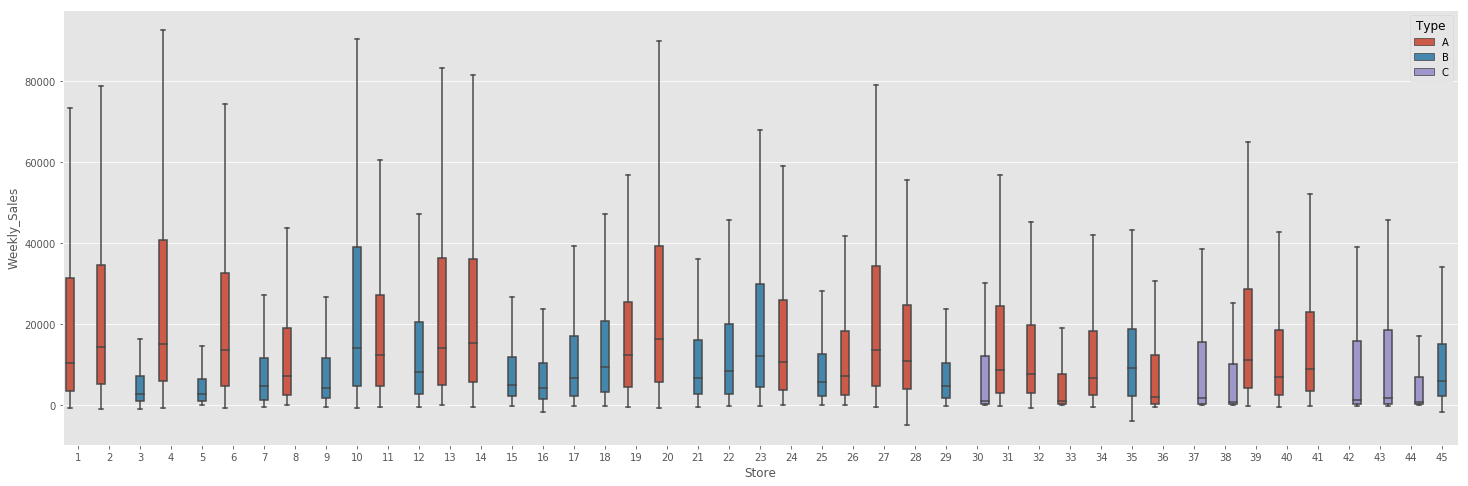

In [16]:
data = pd.concat([train['Store'], train['Weekly_Sales'], train['Type']], axis=1)
f, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=data, showfliers=False, hue="Type")

Store can be the variable giving information on sales
But store is including much intrinsic information of type, size, and department

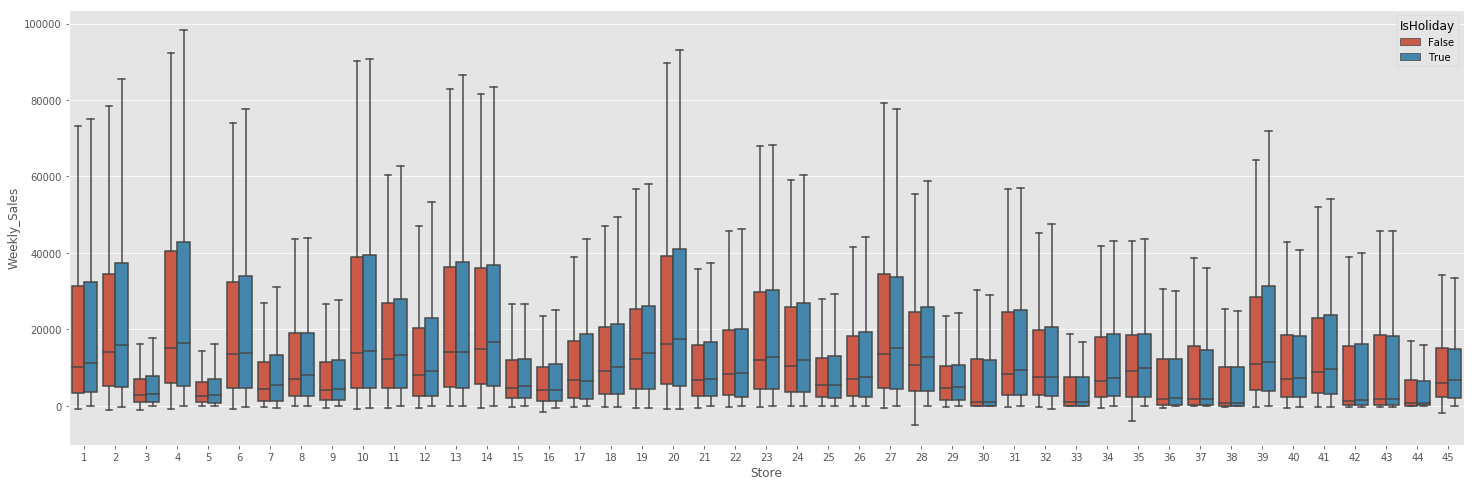

In [17]:
data = pd.concat([train['Store'], train['Weekly_Sales'], train['IsHoliday']], axis=1)
f, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=data, showfliers=False, hue="IsHoliday")

Holiday and Store do not show significant relations but just small higher sales soaring when hoiliday

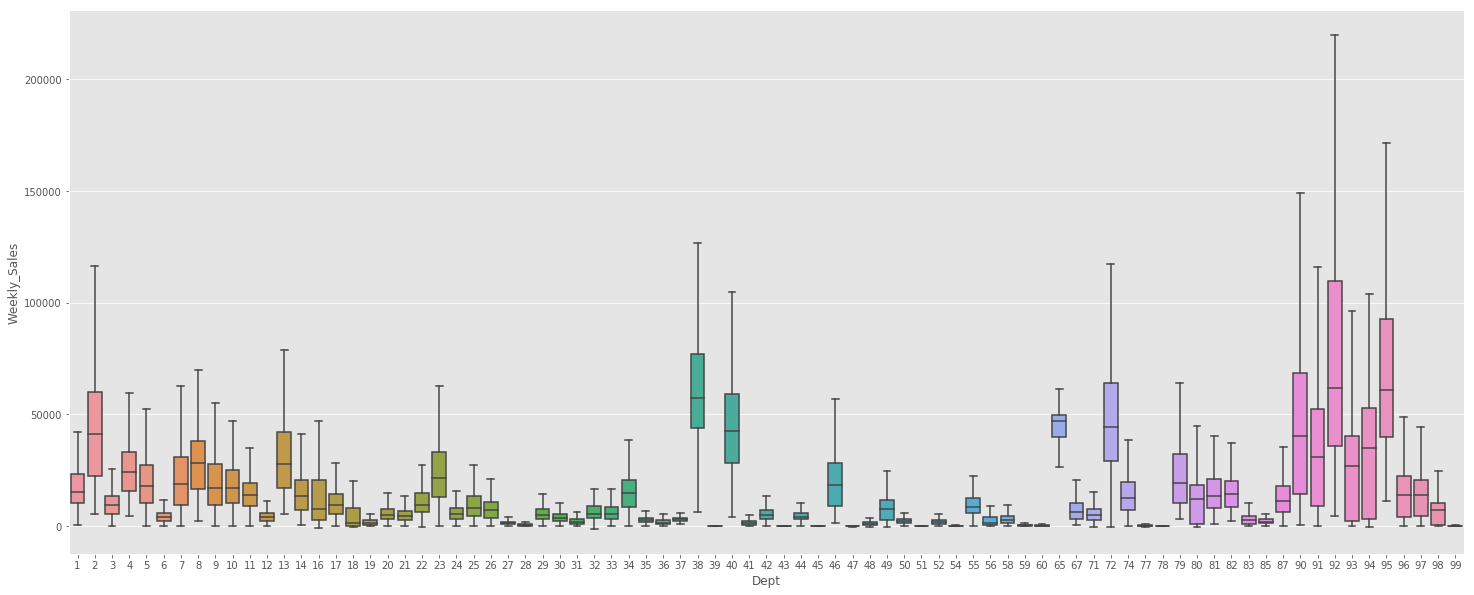

In [18]:
data = pd.concat([train['Dept'], train['Weekly_Sales'], train['Type']], axis=1)
f, ax = plt.subplots(figsize=(25, 10))
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=data, showfliers=False)


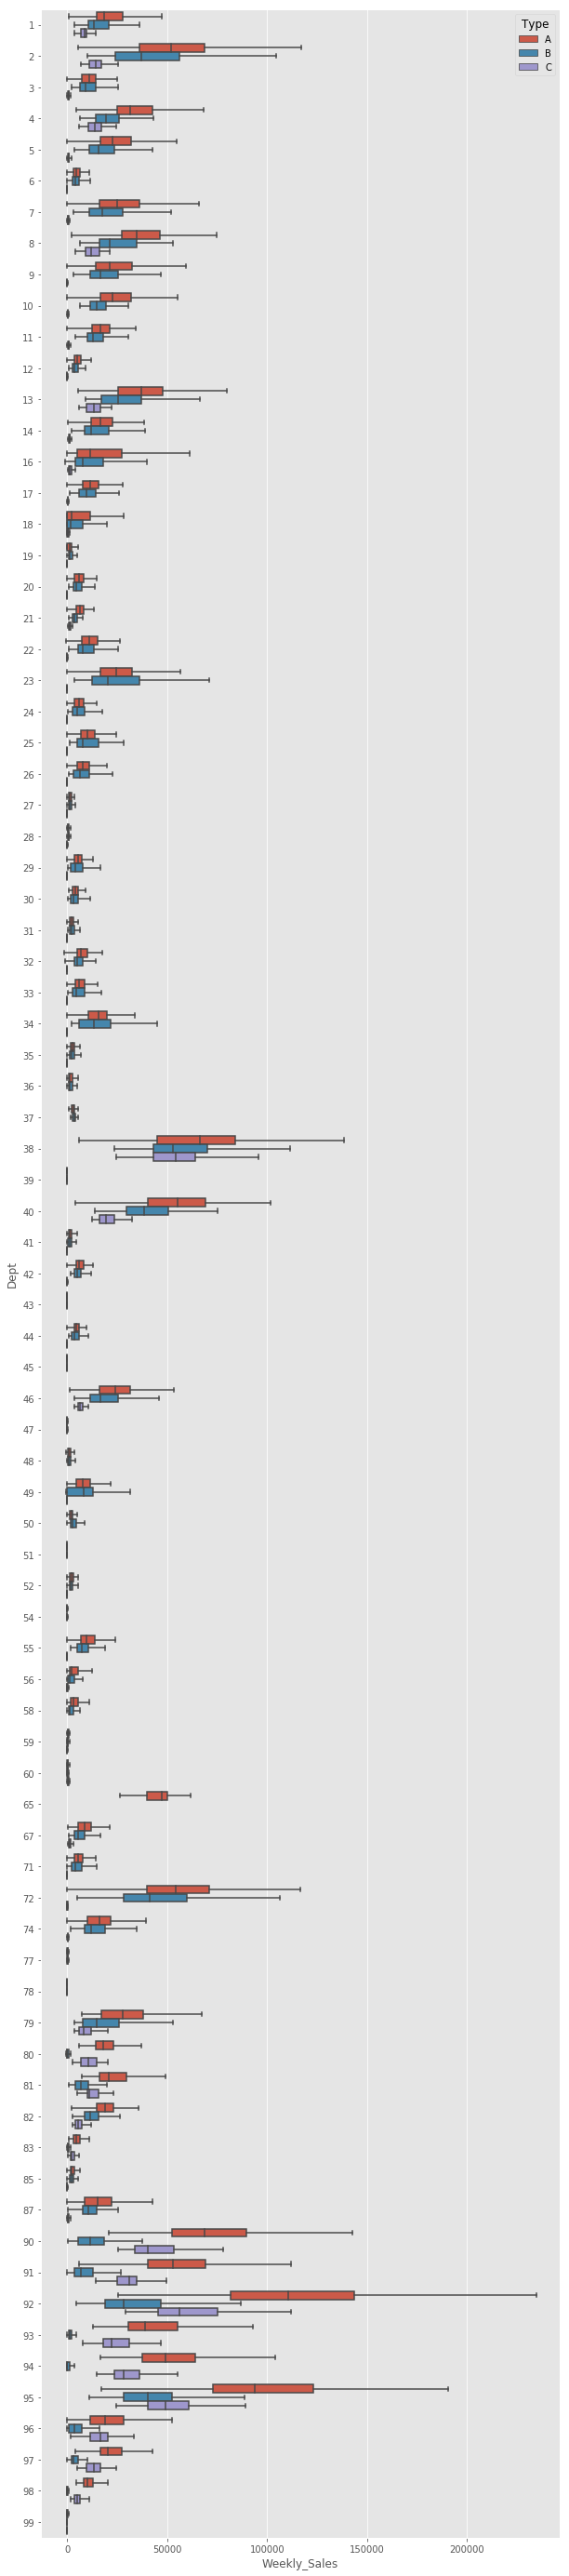

In [19]:
data = pd.concat([train['Dept'], train['Weekly_Sales'], train['Type']], axis=1)
f, ax = plt.subplots(figsize=(10, 50))
fig = sns.boxplot(y='Dept', x='Weekly_Sales', data=data, showfliers=False, hue="Type",orient="h") 

1. Each department shows the different level of sales
2. Department may be the powerful variable to predict sales
3. When department and type of store are considered together, generally department in A type shows the highest sales record
Assumption 4: Type and department may have the interaction effect

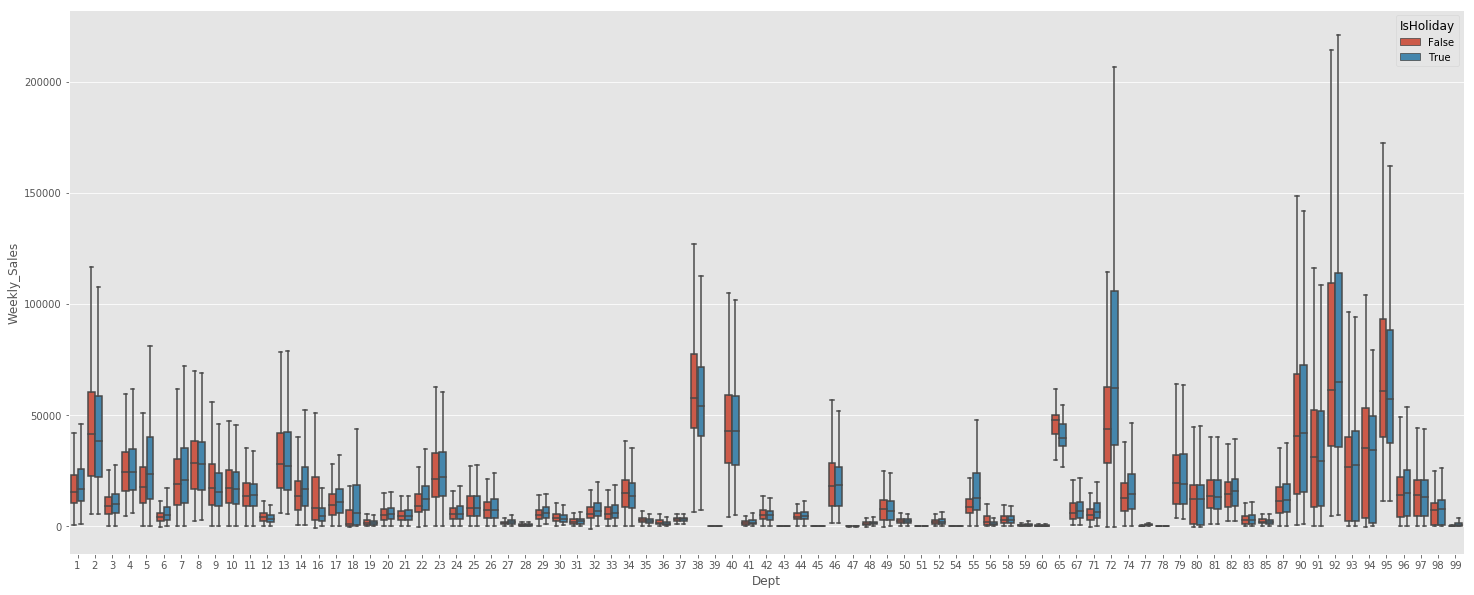

In [20]:
data = pd.concat([train['Dept'], train['Weekly_Sales'], train['IsHoliday']], axis=1)
f, ax = plt.subplots(figsize=(25, 10))
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=data, showfliers=False, hue="IsHoliday")

Unlike store and holiday relation, department and holiday do not explain any relation
72 department shows the highest surge in sales during holiday
However others don't and even more in some dopartments non-holidays' sales is higher.
That means the character of product (department) is different relation with sales

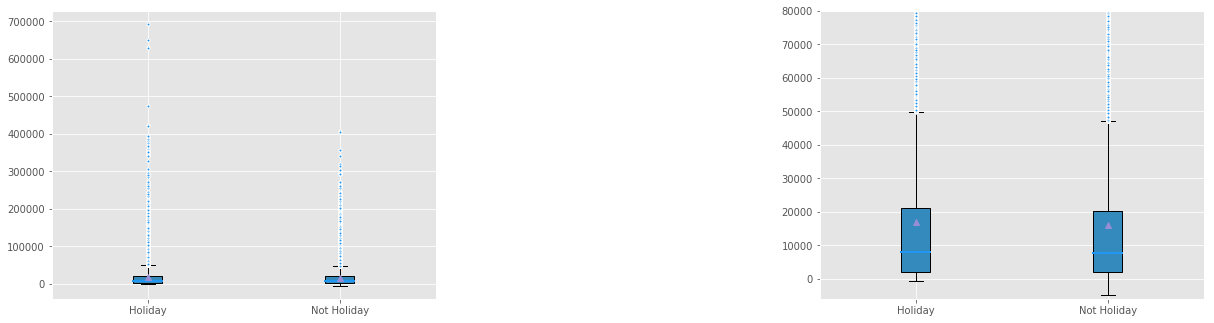

In [21]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1,2, figsize = (20,5))
fig.subplots_adjust(wspace=1, hspace=1)
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

sales_holiday=train[['IsHoliday','Weekly_Sales']]
target=[sales_holiday['Weekly_Sales'].loc[sales_holiday['IsHoliday']==True],sales_holiday['Weekly_Sales'].loc[sales_holiday['IsHoliday']==False]]
labels=['Holiday','Not Holiday']

#median
medianprop={'color':'#2196F3',
            'linewidth': 2,
            'linestyle':'-'}

# outliers

flierprop={'color' : '#EC407A',
          'marker' : 'o',
          'markerfacecolor': '#2196F3',
          'markeredgecolor':'white',
          'markersize' : 3,
          'linestyle' : 'None',
          'linewidth' : 0.1}



axes[0].boxplot(target,labels=labels, patch_artist = 'Patch',
                  showmeans=True,
                  flierprops=flierprop,
                  medianprops=medianprop)




axes[1].boxplot(target,labels=labels, patch_artist = 'Patch',
                  showmeans=True,
                  flierprops=flierprop,
                  medianprops=medianprop)

axes[1].set_ylim(-6000,80000)

plt.show()


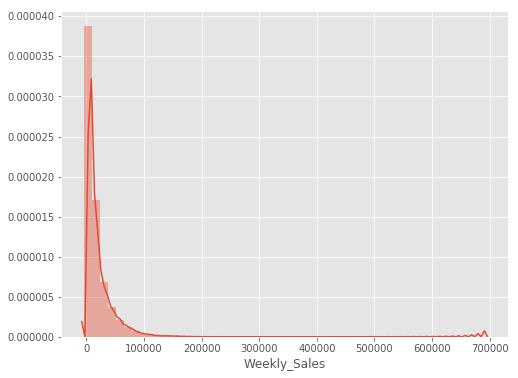

In [22]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['Weekly_Sales'])


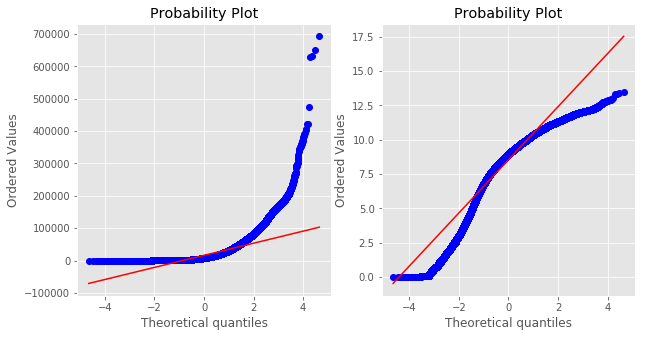

In [23]:
import scipy
fig = plt.figure(figsize = (10,5))

fig.add_subplot(1,2,1)
res = scipy.stats.probplot(train.loc[train['Weekly_Sales']>0,'Weekly_Sales'], plot=plt)

fig.add_subplot(1,2,2)
res = scipy.stats.probplot(np.log1p(train.loc[train['Weekly_Sales']>0,'Weekly_Sales']), plot=plt)


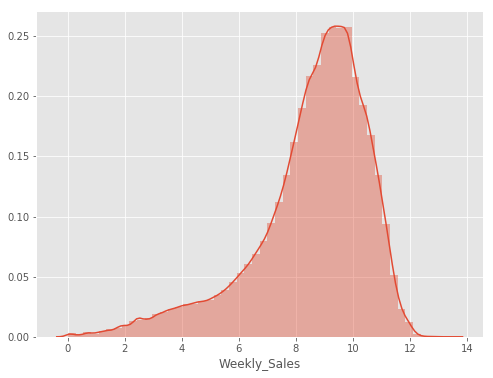

In [24]:
train_over_zero=train[train['Weekly_Sales']>0]
train_below_zero=train[train['Weekly_Sales']<=0]
sales_over_zero = np.log1p(train_over_zero['Weekly_Sales'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(sales_over_zero)

(11090, 6)
   Dept        Date  Store  Weekly_Sales  IsHoliday      Size
0     1  2010-02-05   23.0       19596.0      False  130288.0
1     1  2010-02-12   23.0       32382.0       True  130288.0
2     1  2010-02-19   23.0       24850.0      False  130288.0
3     1  2010-02-26   23.0       15142.0      False  130288.0
4     1  2010-03-05   23.0       16948.0      False  130288.0


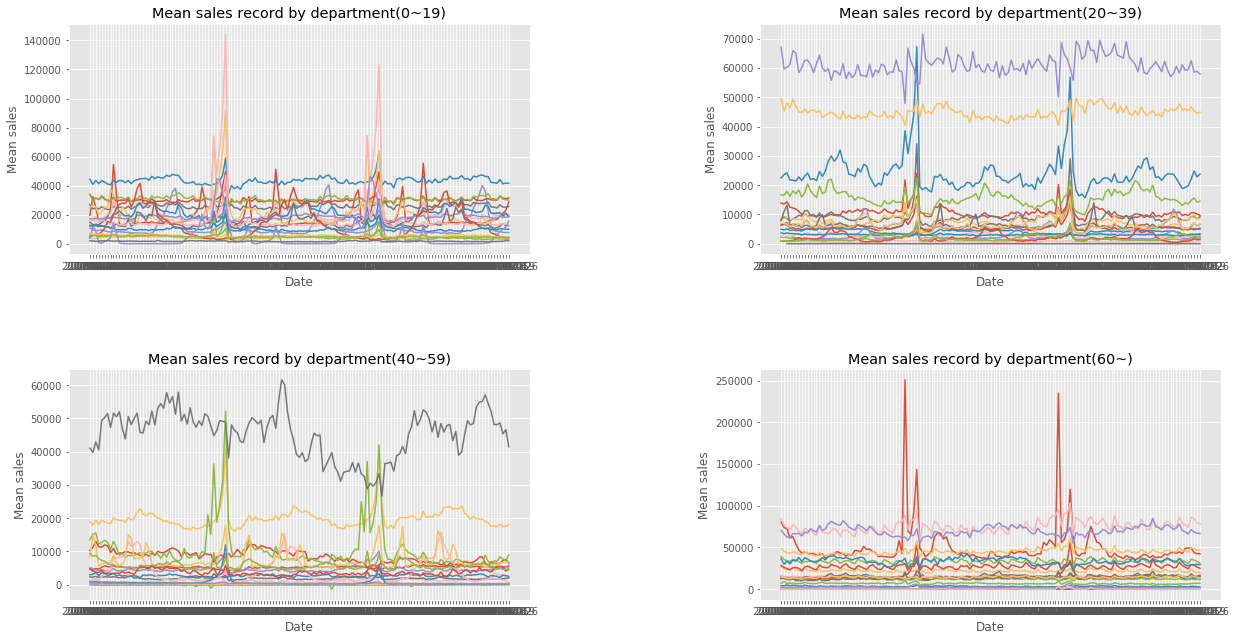

In [25]:
grouped=train.groupby(['Dept','Date']).mean().round(0).reset_index()
print(grouped.shape)
print(grouped.head())
data=grouped[['Dept','Date','Weekly_Sales']]


dept=train['Dept'].unique()
dept.sort()
dept_1=dept[0:20]
dept_2=dept[20:40]
dept_3=dept[40:60]
dept_4=dept[60:]

fig, ax = plt.subplots(2,2,figsize=(20,10))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

for i in dept_1 :
    data_1=data[data['Dept']==i]
    ax[0,0].plot(data_1['Date'], data_1['Weekly_Sales'],label='Dept_1_mean_sales')

for i in dept_2 :
    data_1=data[data['Dept']==i]
    ax[0,1].plot(data_1['Date'], data_1['Weekly_Sales'],label='Dept_1_mean_sales')
    
for i in dept_3 :
    data_1=data[data['Dept']==i]
    ax[1,0].plot(data_1['Date'], data_1['Weekly_Sales'],label='Dept_1_mean_sales')    

for i in dept_4 :
    data_1=data[data['Dept']==i]
    ax[1,1].plot(data_1['Date'], data_1['Weekly_Sales'],label='Dept_1_mean_sales')        
    
ax[0,0].set_title('Mean sales record by department(0~19)')
ax[0,1].set_title('Mean sales record by department(20~39)')
ax[1,0].set_title('Mean sales record by department(40~59)')
ax[1,1].set_title('Mean sales record by department(60~)')


ax[0,0].set_ylabel('Mean sales')
ax[0,0].set_xlabel('Date')
ax[0,1].set_ylabel('Mean sales')
ax[0,1].set_xlabel('Date')
ax[1,0].set_ylabel('Mean sales')
ax[1,0].set_xlabel('Date')
ax[1,1].set_ylabel('Mean sales')
ax[1,1].set_xlabel('Date')


plt.show()

By the line plot, we can see the followings

The sales level is different by department and the sales record level of one department is stable
There is some peaked points around January and May. So there may be an event for high sales
Some departments are highly related with those events. Thus, the sales record goes up steeply around Jan or May

Conclusion 1 : Department is a good feature to predict sales

Couclusion 2 : Date (especially event) is a good feature to predict sales
Like department, time series of sales by store will show trend of sales
Assumption : Like department, store will give a sense of sales level
Assumption_2 : In addition, this will also give the day of the highest sales

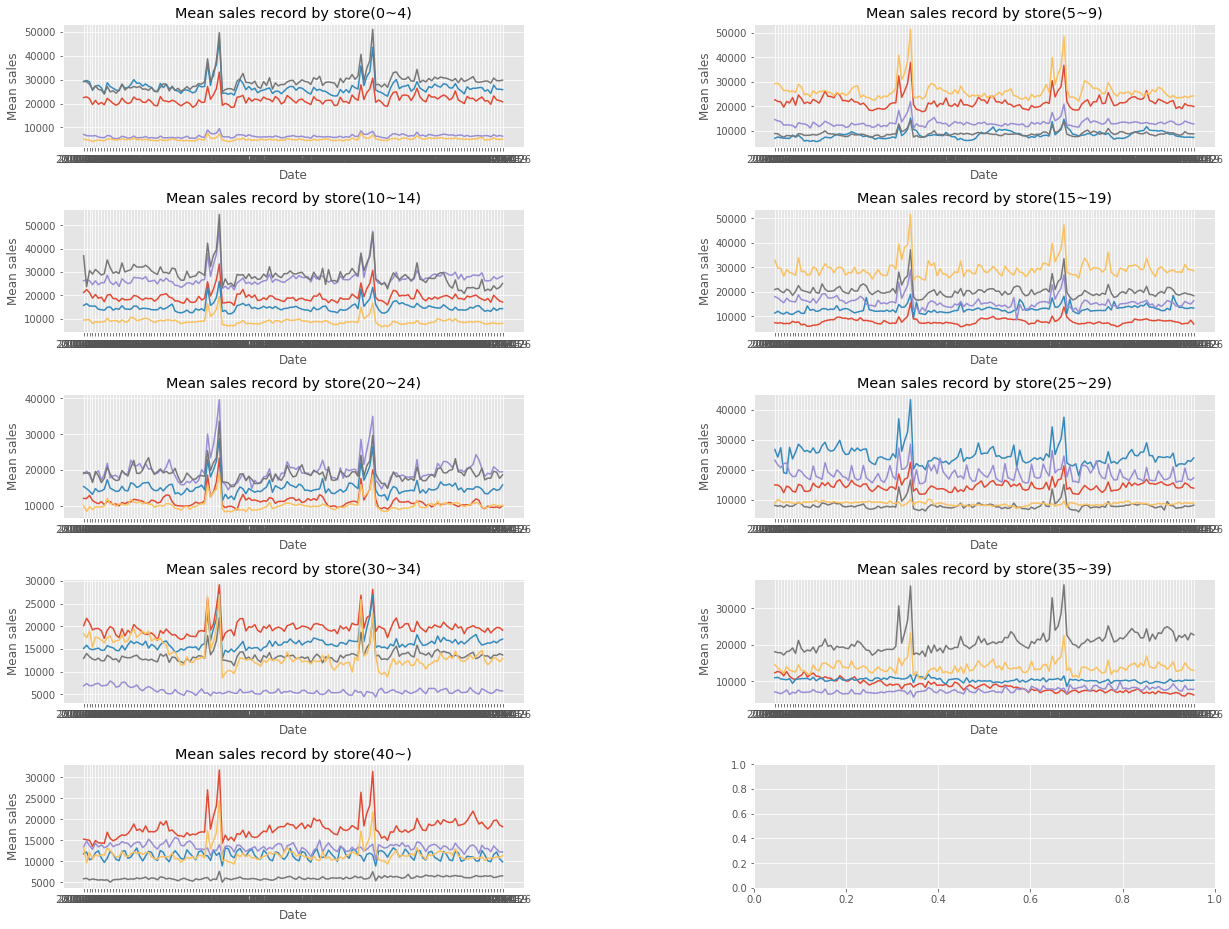

In [27]:
grouped=train.groupby(['Store','Date']).mean().round(0).reset_index()
grouped.shape
grouped.head()

data=grouped[['Store','Date','Weekly_Sales']]
type(data)


store=train['Store'].unique()
store.sort()
store_1=store[0:5]
store_2=store[5:10]
store_3=store[10:15]
store_4=store[15:20]
store_5=store[20:25]
store_6=store[25:30]
store_7=store[30:35]
store_8=store[35:40]
store_9=store[40:]

fig, ax = plt.subplots(5,2,figsize=(20,15))

fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

for i in store_1 :
    data_1=data[data['Store']==i]
    ax[0,0].plot(data_1['Date'], data_1['Weekly_Sales'])
    
for i in store_2 :
    data_2=data[data['Store']==i]
    ax[0,1].plot(data_2['Date'], data_2['Weekly_Sales'])
    
for i in store_3 :
    data_3=data[data['Store']==i]
    ax[1,0].plot(data_3['Date'], data_3['Weekly_Sales'])

for i in store_4 :
    data_4=data[data['Store']==i]
    ax[1,1].plot(data_4['Date'], data_4['Weekly_Sales'])
    
for i in store_5 :
    data_5=data[data['Store']==i]
    ax[2,0].plot(data_5['Date'], data_5['Weekly_Sales'])  

for i in store_6 :
    data_6=data[data['Store']==i]
    ax[2,1].plot(data_6['Date'], data_6['Weekly_Sales'])  

for i in store_7 :
    data_7=data[data['Store']==i]
    ax[3,0].plot(data_7['Date'], data_7['Weekly_Sales'])      

for i in store_8 :
    data_8=data[data['Store']==i]
    ax[3,1].plot(data_8['Date'], data_8['Weekly_Sales'])     
    
for i in store_9 :
    data_9=data[data['Store']==i]
    ax[4,0].plot(data_9['Date'], data_9['Weekly_Sales'])     

    
ax[0,0].set_title('Mean sales record by store(0~4)')
ax[0,1].set_title('Mean sales record by store(5~9)')
ax[1,0].set_title('Mean sales record by store(10~14)')
ax[1,1].set_title('Mean sales record by store(15~19)')
ax[2,0].set_title('Mean sales record by store(20~24)')
ax[2,1].set_title('Mean sales record by store(25~29)')
ax[3,0].set_title('Mean sales record by store(30~34)')
ax[3,1].set_title('Mean sales record by store(35~39)')
ax[4,0].set_title('Mean sales record by store(40~)')



ax[0,0].set_ylabel('Mean sales')
ax[0,0].set_xlabel('Date')
ax[0,1].set_ylabel('Mean sales')
ax[0,1].set_xlabel('Date')
ax[1,0].set_ylabel('Mean sales')
ax[1,0].set_xlabel('Date')
ax[1,1].set_ylabel('Mean sales')
ax[1,1].set_xlabel('Date')
ax[2,0].set_ylabel('Mean sales')
ax[2,0].set_xlabel('Date')
ax[2,1].set_ylabel('Mean sales')
ax[2,1].set_xlabel('Date')
ax[3,0].set_ylabel('Mean sales')
ax[3,0].set_xlabel('Date')
ax[3,1].set_ylabel('Mean sales')
ax[3,1].set_xlabel('Date')
ax[4,0].set_ylabel('Mean sales')
ax[4,0].set_xlabel('Date')



plt.show()